# Importing Libraries

In [1]:
import os
from numpy import expand_dims
from keras.preprocessing.image import load_img, img_to_array
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import struct
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import ZeroPadding2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import load_model

In [2]:
#Define working directory 
BASE_PATH = '/home/keceli/3d-data'

In [3]:
#Checking the directories under the BASE_PATH
dirs = os.listdir(BASE_PATH)
print(dirs)

['a.gif', 'train_data', 'test_lidar', '4.gif', 'test_images', '6.gif', 'src', 'train_maps', 'sample_submission.csv', 'pre-trained', 'testv2.ipynb', 'kitty-format.ipynb', 'train.csv', 'train_lidar', 'yolov3.ipynb', 'preprocess.ipynb', 'artifacts', 'Preliminary-EDA(no-output).ipynb', '.ipynb_checkpoints', '5.gif', 'submission.csv', 'train_images', 'inferencev2.ipynb', 'EDA.ipynb', 'yolov3 (copy).ipynb', '7.gif', 'model.h5', 'maps', 'test_maps', '2.gif', '8.gif', '2d-result', 'sample_data_images.csv', 'lyft3d_bev_test_data.tar.gz', 'lidar', 'images', '3.gif', 'test_data', 'lidar_data_images.csv']


Referred from https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/ for below cell.

# Defining YoloV3 Architecture

In [4]:
# based on https://github.com/experiencor/keras-yolo3
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']),
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection, x]) if skip else x

def define_yolov3():
    input_image = Input(shape=(None, None, 3))
    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    skip_36 = x
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
    skip_61 = x
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])
    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])
    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    return model

class WeightInitialize:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,	= struct.unpack('i', w_f.read(4))
            minor,	= struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))
            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
            transpose = (major > 1000) or (minor > 1000)
            binary = w_f.read()
        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
 
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))
                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))
                    size = np.prod(norm_layer.get_weights()[0].shape)
                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance
                    weights = norm_layer.set_weights([gamma, beta, mean, var])
                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))

    def reset(self):
        self.offset = 0

# Visualize by Intersection over Union (IoU)

In [5]:
# Machine Learning Mastery Jason Brownlee - Object Detection With YOLOv3, page 382
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score
 
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))
 
def network_out(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    intersection_over_union = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            intersection_over_union.append(box)
    return intersection_over_union
 
def aline_iou_yolo(intersection_over_union, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(intersection_over_union)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        intersection_over_union[i].xmin = int((intersection_over_union[i].xmin - x_offset) / x_scale * image_w)
        intersection_over_union[i].xmax = int((intersection_over_union[i].xmax - x_offset) / x_scale * image_w)
        intersection_over_union[i].ymin = int((intersection_over_union[i].ymin - y_offset) / y_scale * image_h)
        intersection_over_union[i].ymax = int((intersection_over_union[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union
 
def non_maximum_suppression(intersection_over_union, nms_thresh):
    if len(intersection_over_union) > 0:
        nb_class = len(intersection_over_union[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in intersection_over_union])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if intersection_over_union[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(intersection_over_union[index_i], intersection_over_union[index_j]) >= nms_thresh:
                    intersection_over_union[index_j].classes[c] = 0

# load and prepare an image
def load_2D_data(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height
 
# get all of the results above a threshold
def get_boxes(intersection_over_union, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in intersection_over_union:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores
 
# draw all results
def IoU(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='red')
    # show the plot
    pyplot.show()

If you first time running weights, run below cell once, then use created 'model.h5' to saving for computation cost.

In [6]:
'''
# Defining the model
model = define_yolov3()

# Load the model weights
weight = WeightInitialize('/home/keceli/3d-data/pre-trained/yolov3/yolov3.weights')

# Set the model weights into the model
weight.load_weights(model)

# Save the model
model.save('model.h5')
'''

"\n# Defining the model\nmodel = define_yolov3()\n\n# Load the model weights\nweight = WeightInitialize('/home/keceli/3d-data/pre-trained/yolov3/yolov3.weights')\n\n# Set the model weights into the model\nweight.load_weights(model)\n\n# Save the model\nmodel.save('model.h5')\n"

In [7]:
# load pre-trained model
model = load_model('model.h5')

In [8]:
#Check the model summary 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, None, None, 3 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, None, None, 3 0           bnorm_0[0][0]                    
______________________________________________________________________________________________

In [9]:
# These Parameters used in the Dataset, on which YOLOv3 was pretrained
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# define the expected input shape for the model
model_width, model_height = 416, 416

# define the probability threshold for detected objects
threshold = 0.3

In [10]:
#First 20 2D data in the test set
test_images = os.listdir(BASE_PATH + "/test_images")[:20]

car 69.33682560920715
car 93.13903450965881
car 95.07254958152771
car 71.64620161056519
car 87.87283301353455
car 53.161489963531494
car 60.08291840553284
car 56.25380873680115


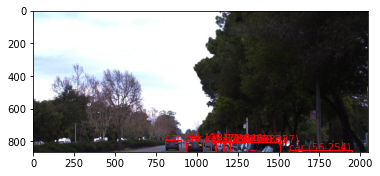

car 95.73798775672913
car 42.270028591156006


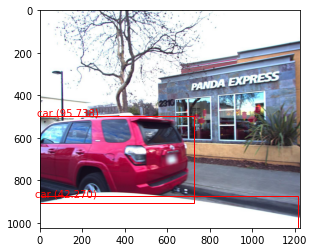

truck 73.20250868797302
bus 34.247589111328125
car 97.43645191192627
car 95.22287845611572
car 99.00760054588318
car 99.21290278434753
traffic light 36.50176525115967
car 76.1311948299408
car 50.33019185066223
car 96.9098687171936
car 95.71031928062439
car 68.35458278656006


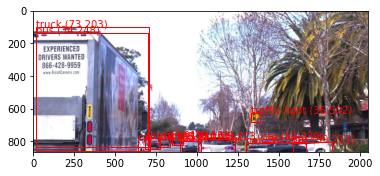

car 82.58243799209595
car 97.94467091560364
car 92.76900887489319
car 86.0360324382782
car 92.82768964767456
car 40.82741141319275
car 76.30054354667664
car 37.89975941181183
car 69.3549394607544
car 76.03739500045776
car 97.12321162223816
car 99.21141862869263
car 96.57859802246094


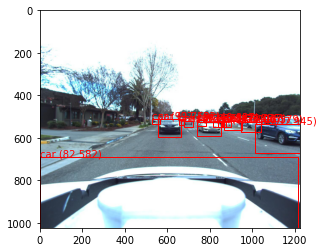

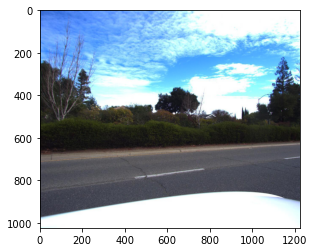

car 82.31790065765381
car 84.58610773086548
car 68.16548109054565
truck 41.365912556648254
truck 64.09942507743835
truck 93.59516501426697
car 31.574919819831848
car 96.74345850944519
car 98.0021059513092
car 59.51486825942993


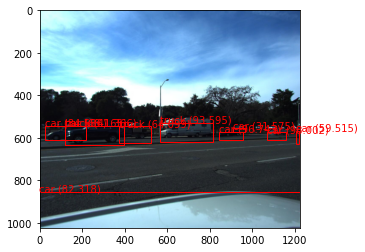

car 96.84841632843018
car 77.41772532463074
car 41.484686732292175
car 61.08357310295105
car 95.29114365577698
car 86.75249814987183


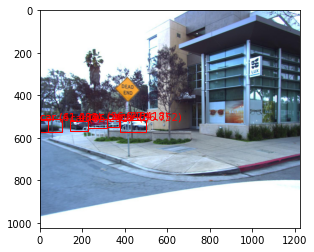

car 93.17108988761902


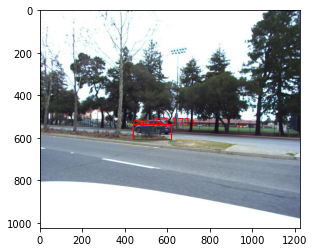

car 99.92579817771912


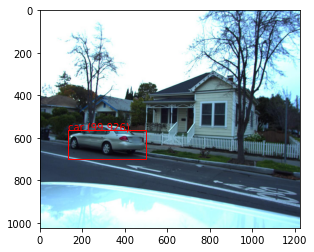

truck 98.06771874427795
car 45.861464738845825
car 49.9567449092865
car 99.61888790130615
car 36.702319979667664
car 43.37202608585358
car 88.96746039390564


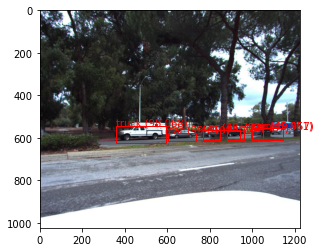

car 42.55450367927551
truck 42.520567774772644
car 51.64405703544617
car 71.45419120788574
car 38.37043046951294
car 88.73245120048523
car 37.1840238571167
car 91.56194925308228
car 88.60832452774048
car 54.58683967590332
car 71.88479900360107
car 96.15141749382019
car 53.59122157096863
car 79.41368818283081
car 41.545671224594116
car 95.67148089408875
car 92.63073801994324
car 51.70474648475647
car 35.39534509181976


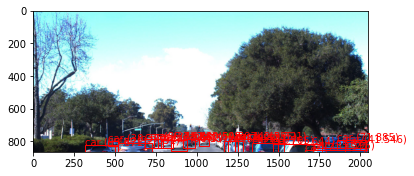

truck 59.10267233848572
bus 33.24832022190094
car 98.9789366722107
car 36.676108837127686
car 99.54250454902649
car 54.607564210891724
car 63.01568150520325
car 43.44204664230347
car 69.81095671653748
car 96.96047306060791
car 41.354960203170776
car 99.39732551574707
car 95.81290483474731
car 92.21472144126892


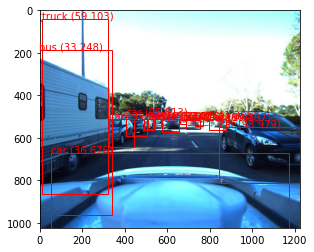

car 95.89366912841797
car 99.88831877708435
car 98.28701615333557
traffic light 72.33529090881348
traffic light 90.6204879283905
traffic light 69.59328055381775
car 90.57767987251282
car 90.93113541603088
car 34.400150179862976
car 91.57095551490784
car 75.0056803226471
car 97.24818468093872
car 96.51069641113281
car 99.303537607193


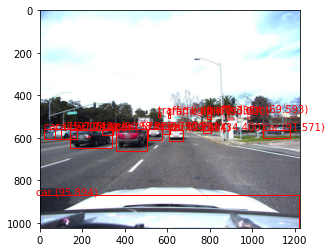

car 98.24936985969543
car 62.2158944606781


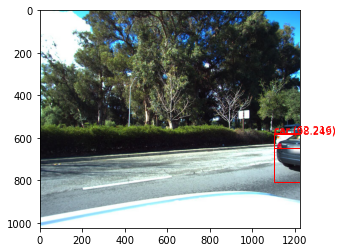

car 95.61048746109009
car 47.01474905014038
car 98.8381028175354
traffic light 96.09795212745667
traffic light 60.654085874557495
traffic light 90.9043550491333
traffic light 69.33861374855042
car 78.78326177597046
car 79.42944169044495
car 90.74147343635559
car 69.69241499900818
car 97.60743975639343


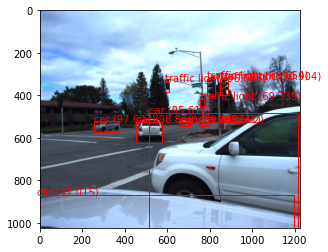

car 90.5858039855957
car 61.32558584213257


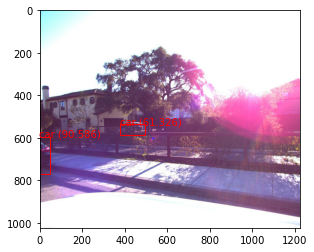

truck 88.76119256019592
car 54.373836517333984
truck 69.59725022315979
car 99.28027391433716
car 47.321513295173645
car 41.67772829532623
car 48.240575194358826
car 91.34989380836487
car 59.06717777252197
car 47.62899875640869
car 80.41974306106567
car 86.63581609725952
car 95.26423811912537
car 98.44319820404053


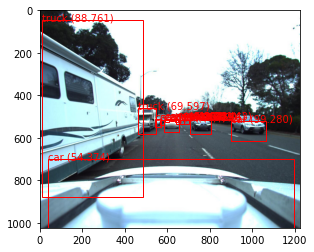

car 99.07032251358032
car 98.12771677970886
car 99.90620017051697
car 55.885761976242065
car 75.77788233757019


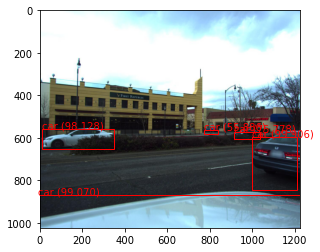

car 99.52185153961182
car 99.9484121799469
car 68.35801601409912
truck 94.0393328666687
truck 74.17517900466919
car 36.444100737571716
truck 83.06267857551575
truck 34.608104825019836
car 98.35688471794128
car 96.45822644233704
bicycle 42.335045337677


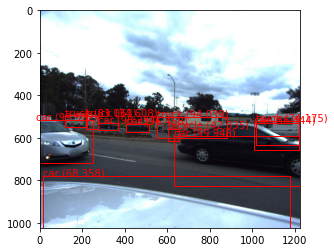

car 53.46035361289978
truck 30.786237120628357
car 78.7631094455719
car 82.63164758682251
car 94.20217871665955
traffic light 97.56790399551392
traffic light 96.84826731681824
traffic light 96.79403305053711
traffic light 86.80776953697205
traffic light 61.1536979675293
car 88.49839568138123
car 33.90110731124878
car 32.07851052284241
person 33.83342921733856
car 61.591553688049316
car 83.26388001441956
car 73.74575138092041


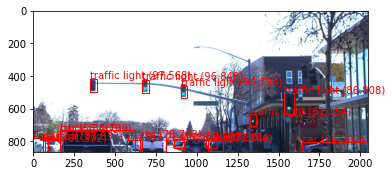

In [11]:
for i in test_images:
    test_set = BASE_PATH + '/test_images/' + i
    
    # load data by default dimensions(416x416)
    image, image_w, image_h = load_2D_data(test_set, (model_width, model_height))
    
    # Predict image
    model_pred = model.predict(image)
    
    # Create IoU
    intersection_over_union = list()
    for i in range(len(model_pred)):
        # decode the output of the network
        intersection_over_union += network_out(model_pred[i][0], anchors[i], threshold, model_height, model_width)

    # correct the sizes of the bounding boxes for the shape of the image
    aline_iou_yolo(intersection_over_union, image_h, image_w, model_height, model_width)

    # suppress non-maximal IoU
    non_maximum_suppression(intersection_over_union, 0.5)

    # define the labels which were used in pre-trained model in COCO
    labelMap = [
    "person",         "bicycle",    "car",           "motorbike",     "aeroplane",   "bus",           "train",
    "truck",          "boat",       "traffic light", "fire hydrant",  "stop sign",   "parking meter", "bench",
    "bird",           "cat",        "dog"
]

    # Details of the detected 2D objects with their percentage.
    v_boxes, v_labels, v_scores = get_boxes(intersection_over_union, labelMap, threshold)

    # Print the labels in the single instance
    for i in range(len(v_boxes)):
        print(v_labels[i], v_scores[i])

    # Draw IoU
    IoU(test_set, v_boxes, v_labels, v_scores)